# Video Prediction

## 1) Upload the model pre-trained

In [1]:
from libraries.video_utils import *
from libraries.embeddings_utils import *
%load_ext autoreload
%autoreload 2
import joblib
import os

project_dir = f"{os.getcwd().split('SIDS_revelation_project')[0]}SIDS_revelation_project/"
image_dataset_path = f"{project_dir}datasets/onback_onstomach_v3"
model_path_fd = f"{project_dir}/models/4.fd_weights/best.pt"
model_path_pe = f"{project_dir}/models/2.pe_weights/best.pt"
clf_path = f"{project_dir}/classifiers/XGBClassifier_84_features.pkl"
clf = joblib.load(clf_path)

/opt/anaconda3/envs/SIDS_revelation_project/lib/python3.11/pickle.py:1718: UserWarning: [18:15:43] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


## 2) Upload the Builder

In [2]:
builder = EmbeddingBuilder(weights_path_fd=model_path_fd,dataset_path=image_dataset_path,mode= "load",weights_path_pe=model_path_pe)


Extracting dataset info from .coco.json file:---------------------------------------------
Dataset contains 4158 valid samples, and labels are {'baby_on_back': 1, 'baby_on_stomach': 2}
------------------------------------------------------------------------------------------

Loading features from .csv----------------------------------------------------------------
Features loaded succesfully, in particular there are 4158 files in the dataset
------------------------------------------------------------------------------------------

Embedding builder initialized successfully------------------------------------------------
Face detection model: 4 (YOLOv8)
Dataset: /Users/lorenzodimaio/Download/SIDS_revelation_project/datasets/onback_onstomach_v3
Dataset dimension: 4158
Dataset labels: {'baby_safe': 0, 'baby_unsafe': 1}
------------------------------------------------------------------------------------------


## 3) Process Video without filter
Processes a video by applying object detection (YOLO) and keypoint-based classification.

This function reads a video file, performs object detection to extract facial keypoints,
generates features, and applies a trained classifier to predict the baby's position
(e.g., "On Back" or "On Stomach") frame by frame. Bounding boxes and prediction labels
are overlaid on the video, which is saved to disk and optionally displayed.

Parameters:
- input_video_path (str): Path to the input video file.
- builder: An instance of the EmbeddingBuilder for keypoint extraction and feature generation.
- clf: A trained classification model for predicting the baby’s position.
- show_confidences (bool): If True, displays confidence scores on bounding boxes.
- show_all_boxes (bool): If True, draws all detected bounding boxes; if False, only shows the "head".
- default_fps (int): Fallback FPS value if the original video FPS is unavailable.


In [28]:
valid_boxes_per_frame_without_filter = process_video(input_video_path="video/baby_1_kpt.mp4",
                                                     builder=builder,
                                                     use_filters=False,
                                                     clf=clf,
                                                     show_all_boxes=True,
                                                     show_all_kpt=True,
                                                     show_confidences=True,
                                                     default_fps=20)

FPS processing: 20


## 4) Process Video With Filter
The function applies dynamic contrast and brightness filters based on the quality of keypoint detection:
- Filter Levels (0-3):
Level 0 means no filter; levels 1 to 3 apply increasing adjustments to contrast (alpha) and brightness (beta) using cv2.convertScaleAbs.
- Adaptive Filtering:
The filter level adjusts dynamically depending on recent keypoint detection success over the last 25 frames:
	- If detection success rate is high (>50%), filters are disabled (level 0).
	- If success rate is low (<30%), filter intensity increases progressively to improve visibility.
- Purpose:
These filters enhance image quality in challenging conditions (e.g., low light), helping the model better detect keypoints and improve prediction accuracy.

In [27]:
valid_boxes_per_frame_with_filter = process_video(input_video_path="video/baby_6_kpt.mp4",
                                                  builder=builder,
                                                  clf=clf,
                                                  use_filters=True,
                                                  show_all_boxes=True,
                                                  show_all_kpt=True,
                                                  show_confidences=True,
                                                  default_fps=60,
                                                  upper_thresh=0.65,
                                                  lower_thresh=0.35)

FPS processing: 24.0


# 5) Comparison Prediction With_filter vs Without_filter

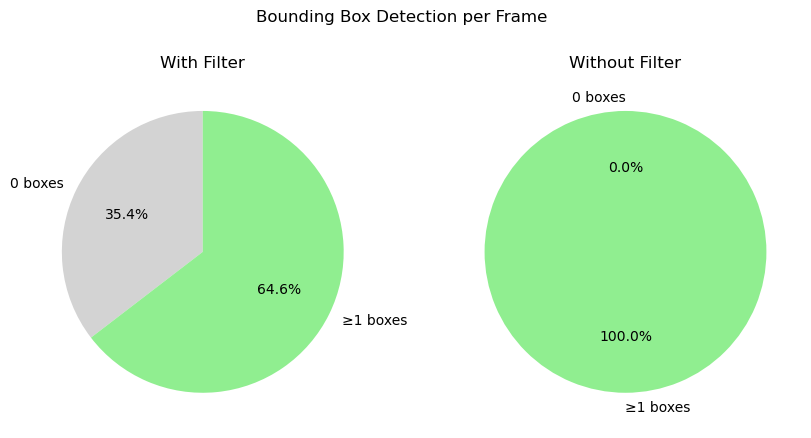

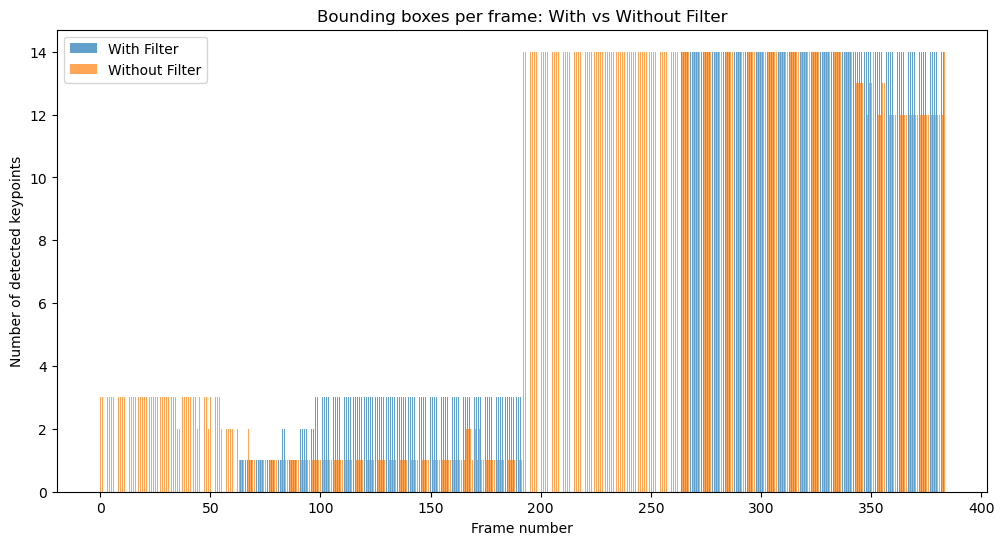

Total with filter: 2005
Total without filter: 2934


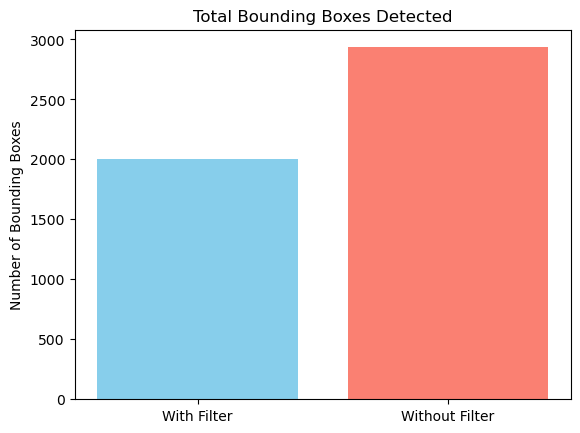

In [29]:
plot_comparison(valid_boxes_per_frame_with_filter, valid_boxes_per_frame_without_filter)